In [1]:
#this notebook is just for testing and playing around with the GPLVM model
!source /vol/cuda/11.2.1-cudnn8.1.0.77/setup.sh 
import os
import sys
from pathlib import Path
from optparse import check_choice
from gpflow.base import Parameter
from gpflow.config import default_float
from gpflow.utilities import positive
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm
from tqdm import trange
from typing import Optional
import gpflow
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import dill
import tensorflow as tf
import tensorflow_probability as tfp
from collections import defaultdict
from collections import namedtuple

#add parent directory to path
work_dir = os.path.abspath('')
sys.path.insert(0, os.path.join(
    os.path.dirname(os.path.dirname(work_dir)), 'gplvm_causal_discovery'
))

from models.BayesGPLVM import BayesianGPLVM
from models.PartObsBayesianGPLVM import PartObsBayesianGPLVM
from models.GeneralisedUnsupGPLVM import GeneralisedUnsupGPLVM
from models.GeneralisedGPLVM import GeneralisedGPLVM
from data.get_data import get_an_pairs_dataset
from data.get_data import get_tueb_dataset
from data.get_data import get_inf_data

#del sys.path[0], sys, os

#set manual color cycle
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=['lightseagreen', 'salmon', 'slateblue', 'gold', 'mediumorchid', '#116b67', '#9a352d', '#3f3c6f', '#7b5a00', '#6d215e'])



2024-02-05 20:19:43.054615: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2024-02-05 20:19:43.054637: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
def get_an_pairs(work_dir, pair_index):
    """
    Get the AN pairs dataset
    """
    print("Loading AN pairs dataset...")
    x, y, weight, target = get_an_pairs_dataset(
        data_path=f"{work_dir}/data/an_pairs/files",
        pair_index=pair_index
    )
    return x, y, target

def get_tueb(work_dir, pair_index):
    """
    Get the Tuebingen dataset
    """
    print("Loading Tuebingen pair {}".format(pair_index))
    x, y, weight, target, pair_index = get_tueb_dataset(
        data_path=f"{work_dir}/data/tueb/files",
        pair_index=pair_index
    )
    return x, y, target, pair_index


def preprocess(x, y, test_size=0.2, shuffle_seed=0):
    '''
    Normalise and shuffle data, then split into train and test sets

    Args:
        data: data to be split (x, y) shape (2, n, 1)
        test_size: proportion of data to use for testing

    Returns:
        trainval_data_norm: normalised train and validation data (x, y)
        test_data_norm: normalised test data (x, y)
    '''

    #random generator
    rng = np.random.default_rng(seed=shuffle_seed)

    #shuffle data
    # idx = np.random.permutation(x.shape[0])
    idx = rng.permutation(x.shape[0])
    data = np.concatenate((x, y), axis=1)[idx]

    if test_size == 0:
        scaler_train = StandardScaler()
        train_data_norm = scaler_train.fit_transform(data)
        x_train_norm = train_data_norm.T[0].reshape(-1, 1)
        y_train_norm = train_data_norm.T[1].reshape(-1, 1)
        return (x_train_norm, y_train_norm), None
    
    else:
        #split data into train and test
        test_n = int(test_size * x.shape[0])
        data_trainval = data[:-test_n]
        data_test = data[-test_n:]

        #normalise data: fit scaler to trainval data, then transform trainval and test data
        scaler_trainval = StandardScaler()
        trainval_data_norm = scaler_trainval.fit_transform(data_trainval)
        test_data_norm = scaler_trainval.transform(data_test)

        #split into x and y 
        x_trainval_norm = trainval_data_norm.T[0].reshape(-1, 1)
        y_trainval_norm = trainval_data_norm.T[1].reshape(-1, 1)
        x_test_norm = test_data_norm.T[0].reshape(-1, 1)
        y_test_norm = test_data_norm.T[1].reshape(-1, 1)

        return (x_trainval_norm, y_trainval_norm), (x_test_norm, y_test_norm)

    

# synthetic data - crossval

Loading Tuebingen dataset...


Load cause-effect pairs:   0%|          | 0/108 [00:00<?, ?it/s]

Load cause-effect pairs: 100%|██████████| 108/108 [00:00<00:00, 136.40it/s]


pair 54 | target: anti-causal
trainval_data:  (314, 3) (314, 2)
test_data:  (78, 3) (78, 2)
Causal direction
(314, 3) (314, 2)
target:  -1


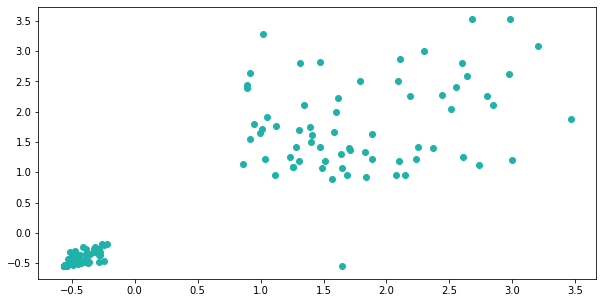

Anti-causal direction
(314, 2) (314, 3)
target:  -1


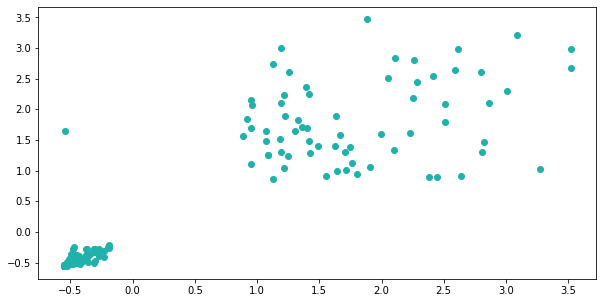

In [18]:

pair_index = 54
i = pair_index - 1

#x, y, target = get_an_pairs('../', pair_index)
x, y, target = get_tueb('../', pair_index)
# print(x_all)
# print(y_all)



print("pair {} |".format(pair_index), end=' ')
print("target: {}".format('causal' if target == 1 else 'anti-causal'))


#preprocess data - normalise, shuffle and split into train and test sets
trainval_data, test_data = preprocess(x, y, test_size=0.2)
print('trainval_data: ', trainval_data[0].shape, trainval_data[1].shape)
print('test_data: ', test_data[0].shape, test_data[1].shape)


# do the following in both directions (x->y and y->x)
for causal in [True, False]:
    if causal:
        print('Causal direction')
        # x_trainval should be shape (n, 1) from (2, n, 1)
        x_trainval, y_trainval = trainval_data[0], trainval_data[1]
        print(x_trainval.shape, y_trainval.shape)

    else:
        print('Anti-causal direction')
        # x_trainval should be shape (n, 1) from (2, n, 1)
        x_trainval, y_trainval = trainval_data[1], trainval_data[0]
        print(x_trainval.shape, y_trainval.shape)


    #plot data
    print('target: ', target)
    plt.figure(figsize=(10, 5))
    plt.scatter(x_trainval[:, 0], y_trainval[:, 0], label='trainval')
    plt.show()
    


pair 3 | target: causal


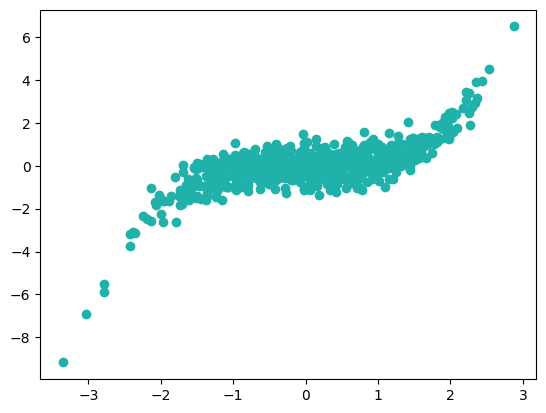

Trying: len_obs=1.00000, len_lat=1.00000, sq_exp_var=1.00000, lin_var=1.00000, likelihood_variance=1.00000


Adam opt: latent hyperparameters for conditional model


NameError: name 'train_dataset' is not defined

In [5]:
pair_index = 3

i = pair_index - 1
#x, y, target = x_all[i], y_all[i], target_all[i]


print("pair {} |".format(pair_index), end=' ')
print("target: {}".format('causal' if target == 1 else 'anti-causal'))

#preprocess data - normalise, shuffle and split into train and test sets
trainval_data, test_data = preprocess(x, y, test_size=0.2)

# trainval_data = np.flip(trainval_data, axis=0)

def train_conditional_model(
        data: np.ndarray,
        num_inducing: int,
        hyperparams: dict,
        causal: Optional[bool] = None,
        run_number: Optional[int] = None,
        random_restart_number: Optional[int] = None,
        pair_index: Optional[int] = 0,
        plot_fit: Optional[bool] = False,
        adam: int = 10,
        scipy: int = 10,
        optimiser: str = "adam",
        mini_batch_size: int = 100,
        ):
        """
        Train a conditional model using a partially observed GPLVM.
        """

        # unpack data
        x, y = data[0], data[1]

        #extract hyperparams
        kernel_len_obs = hyperparams["len_obs"]
        kernel_len_lat = hyperparams["len_lat"]
        sq_exp_var = hyperparams["sq_exp_var"]
        likelihood_variance = hyperparams["likelihood_variance"]
        lin_var = hyperparams["lin_var"]


        #print hyperparams
        tf.print("Trying: len_obs=%.5f, len_lat=%.5f, sq_exp_var=%.5f, lin_var=%.5f, likelihood_variance=%.5f"%(
            kernel_len_obs, kernel_len_lat, sq_exp_var, lin_var, likelihood_variance
        ))


        latent_dim = 1

        # Define hyperparameters
        X_mean_init = 0.1 * tf.cast(y, default_float())
        sq_exp = gpflow.kernels.SquaredExponential(lengthscales=[kernel_len_obs] + [kernel_len_lat])
        sq_exp.variance.assign(sq_exp_var + 1e-20)
        linear_kernel = gpflow.kernels.Linear(variance=lin_var + 1e-20)

        X_var_init = tf.cast(
            np.random.uniform(0, 0.1, (y.shape[0], latent_dim)), default_float()
        )
        x_prior_var = tf.ones((y.shape[0], latent_dim), dtype=default_float())
        kernel = gpflow.kernels.Sum([sq_exp, linear_kernel])
        inducing_variable = gpflow.inducing_variables.InducingPoints(
            np.concatenate(
                [
                    np.linspace(x.min(), x.max(), num_inducing).reshape(-1, 1),
                    np.random.randn(num_inducing, 1),
                ],
                axis=1
            )
        )

        # Define conditional model
        # conditional_model = PartObsBayesianGPLVM(
        #     data=y,
        #     in_data=x,
        #     kernel=kernel,
        #     X_data_mean=X_mean_init,
        #     X_data_var=X_var_init,
        #     X_prior_var=x_prior_var,
        #     jitter=1e-6,
        #     inducing_variable=inducing_variable
        # )
        conditional_model = GeneralisedGPLVM(
            kernel=kernel,
            X_data_mean=X_mean_init,
            X_data_var=X_var_init,
            likelihood=gpflow.likelihoods.Gaussian(variance=likelihood_variance),
            num_mc_samples=10,
            batch_size=mini_batch_size,
            inducing_variable=inducing_variable
        )

        conditional_model.likelihood.variance = Parameter(
            likelihood_variance, transform=positive(lower=1e-5)
        )

        

        tf.print("Adam opt: latent hyperparameters for conditional model")
        # Do not train kernel and likelihood, determined by CV
        gpflow.utilities.set_trainable(conditional_model.kernel, True)
        gpflow.utilities.set_trainable(conditional_model.likelihood, True)

        # Train latent variables with Adam first
        gpflow.utilities.set_trainable(conditional_model.X_data_mean, True)
        gpflow.utilities.set_trainable(conditional_model.X_data_var, True)
        gpflow.utilities.set_trainable(conditional_model.inducing_variable, True)

        train_iter = iter(train_dataset.batch(minibatch_size))
        loss_fn = conditional_model.training_loss_closure(train_iter, compile=True)

        if optimiser == "adam":
            adam_vars = conditional_model.trainable_variables
            adam_opt = tf.optimizers.Adam(0.05)

            @tf.function
            def optimisation_step():
                adam_opt.minimize(loss_fn, adam_vars)

        elif optimiser == "natgrad":
            natgrad_opt = gpflow.optimizers.NaturalGradient(gamma=1.0)
            variational_params = [(conditional_model.q_mu, conditional_model.q_sqrt)]

            @tf.function
            def optimisation_step():
                natgrad_opt.minimize(
                    loss_fn, var_list=variational_params
                )
                adam_opt.minimize(loss_fn, var_list=model.trainable_variables)

        epochs = int(adam)
        logf = []
        iterator = range(epochs)
        for step in tqdm(iterator, desc=f"Optimising with {optimiser}"):
            optimisation_step()
            neg_elbo = -loss_fn().numpy()
            logf.append(neg_elbo)
            # It is possible to include a stopping criteria here. However there
            # is a risk that the training will be stopped too soon and the
            # ELBO achieved will not be as high as it could be

        # Plot ELBO
        plt.plot(-np.array(logf), marker=".")
        plt.xlabel("iteration")
        plt.ylabel("ELBO")
        plt.show()
        plt.close()
        
        # Train latent variables after Adam
        tf.print("Scipy opt: latent hyperparameters for conditional model")
 
        opt = gpflow.optimizers.Scipy()
        opt_logs = opt.minimize(
            conditional_model.training_loss,
            conditional_model.trainable_variables,
            options=dict(maxiter=scipy),
        )
        print(opt_logs)
        #tf.print("ELBO:", - conditional_model.elbo())

        if plot_fit:
            num_lat = 50
            num_gp = 50
            Xnew = np.linspace(x.min(), x.max(), 50).reshape(-1, 1)
            samples = conditional_model.predict_full_samples_layer(Xnew, 
                                                         obs_noise=False, 
                                                         num_latent_samples=num_lat,
                                                         num_gp_samples=num_gp)
            
            samples = samples.numpy().reshape(num_gp, num_lat, -1)
            
            Xnew = np.tile(Xnew, (num_gp, num_lat, 1))
            
            plt.scatter(Xnew, samples, color="C0", alpha=0.01, label="samples", marker=".", edgecolors="none", s=200)
            plt.scatter(x, y, color="C2", label="data", marker=".", alpha=0.5, edgecolors="none", s=100)

            #legend should have alpha 1
            leg = plt.legend()
            for lh in leg.legendHandles:
                lh.set_alpha(1)
        
            plt.show()
            plt.close()

        else:
            pass

        return conditional_model

#data is np array of shape (2, n, 1) from x and y trainval
plt.scatter(trainval_data[0], trainval_data[1])
plt.show()
plt.close()
hyperparams = {
    "len_obs": 1.0,
    "len_lat": 1.0,
    "sq_exp_var": 1.0,
    "lin_var": 1.0,
    "likelihood_variance": 1.0,
}


train_conditional_model(
    data=trainval_data,
    num_inducing=100,
    hyperparams=hyperparams,
    plot_fit=True,
    adam=100,
    scipy=10,
    optimiser="natgrad",
    mini_batch_size=50,
)




In [10]:
import numpy as np
import pandas as pd

print('trainval_data.shape', trainval_data.shape)
data = trainval_data[0].reshape(-1, trainval_data[0].shape[0], 1)
#data =trainval_data
k = 5

#get folds

folds = np.array_split(data, k, axis=1)

fold_losses = pd.DataFrame(columns=['train_loss', 'val_loss']) #df to store losses for each fold

for i in range(k):
    tf.print("Fold: {}/{}".format(i+1, k))

    #get train and validation data for fold
    train_data = np.concatenate([pairs for j, pairs in enumerate(folds) if j != i], axis=1)
    val_data = folds[i]

    print(train_data.shape, val_data.shape)

    #normalise data
    scaler_train = StandardScaler()
    train_data_norm = scaler_train.fit_transform(train_data.reshape(-1, train_data.shape[0])).reshape(train_data.shape)
    val_data_norm = scaler_train.transform(val_data.reshape(-1, val_data.shape[0])).reshape(val_data.shape)

trainval_data.shape (2, 800, 1)
Fold: 1/5
(1, 640, 1) (1, 160, 1)
Fold: 2/5
(1, 640, 1) (1, 160, 1)
Fold: 3/5
(1, 640, 1) (1, 160, 1)
Fold: 4/5
(1, 640, 1) (1, 160, 1)
Fold: 5/5
(1, 640, 1) (1, 160, 1)


In [ ]:
CORE = 10
n_datasets = 1

for i in range(CORE * n_datasets, (CORE + 1) * n_datasets):
    pair_index = i + 1
    print(pair_index)

11


In [ ]:
import pandas as pd


loss_table = pd.DataFrame({'dataset': pd.Series([], dtype='str'),
                           'model': pd.Series([], dtype='str'),
                           'causal': pd.Series([], dtype='bool'),})

new_row1 = pd.DataFrame({'dataset': 'an_pairs',
            'model': 'marginal',
            'causal': True}, index=[0])

new_row2 = pd.DataFrame({'dataset': 'an_pairs',
            'model': 'marginal',
            'causal': False}, index=[0])

loss_table = pd.concat([loss_table, new_row1], ignore_index=True)
loss_table = pd.concat([loss_table, new_row2], ignore_index=True)

print(loss_table)


    dataset     model  causal
0  an_pairs  marginal    True
1  an_pairs  marginal   False


In [34]:

import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

def getFolds_marginal(data, k):
    '''
    Split data into k folds when tuple with shape ([n, 1])
    '''

    #split data into k folds throwing away any remainder (if n % k != 0)
    remainder = data[0].shape[0] % k
    folds = np.array_split(data[0][:data[0].shape[0] - remainder], k, axis=0)


    #return an array of tuples
    return [(fold, ) for fold in folds]

def getFolds_conditional(data, k):
    '''
    Split data into k folds when tuple with shape ([n, 1], [n, 1])
    '''

    folds_x = np.array_split(data[0], k, axis=0)
    folds_y = np.array_split(data[1], k, axis=0)

    #return an array of tuples
    return [(fold_x, fold_y) for fold_x, fold_y in zip(folds_x, folds_y)]

def getTrainVal_marginal(folds, i):
    '''
    Get train and validation data for fold i
    '''

    val_data = folds[i]
    #everything else is train data, so concatenate all other folds into a tuple of one array
    train_data = np.concatenate([fold for j, fold in enumerate(folds) if j != i], axis=0)

    #normalise data (fit scaler to train data, then transform train and val data)
    scaler_train = StandardScaler()
    train_data_norm = (scaler_train.fit_transform(train_data[0]), )
    val_data_norm = (scaler_train.transform(val_data[0]), )

    return train_data_norm, val_data_norm


def getTrainVal_conditional(folds, i):
    '''
    Get train and validation data for fold i
    '''

    val_data = folds[i]
    #everything else is train data, so concatenate all other folds into a tuple of two arrays
    train_data_x = np.concatenate([fold[0] for j, fold in enumerate(folds) if j != i], axis=0)
    train_data_y = np.concatenate([fold[1] for j, fold in enumerate(folds) if j != i], axis=0)
    train_data = (train_data_x, train_data_y)

    #normalise data (fit scaler to train data, then transform train and val data)
    scaler_train_x = StandardScaler()
    scaler_train_y = StandardScaler()
    train_data_norm = (scaler_train_x.fit_transform(train_data[0]), scaler_train_y.fit_transform(train_data[1]))
    val_data_norm = (scaler_train_x.transform(val_data[0]), scaler_train_y.transform(val_data[1]))

    return train_data_norm, val_data_norm


data = (np.array([[1], [2], [3], [4], [5], [6], [7], [8], [9], [10]]),)
        #np.array([11, 12, 13, 14, 15, 16, 17, 18, 19, 20]).reshape(-1, 1))


k = 9

#get folds
folds = getFolds_marginal(data, k)
print('folds: ', folds)

fold_losses = pd.DataFrame(columns=['train_loss', 'val_loss']) #df to store losses for each fold

for i in range(k):
    print("Fold: {}/{}".format(i+1, k))

    #get train and validation data for fold
    train_data, val_data = getTrainVal_marginal(folds, i)


    



folds:  [(array([[1]]),), (array([[2]]),), (array([[3]]),), (array([[4]]),), (array([[5]]),), (array([[6]]),), (array([[7]]),), (array([[8]]),), (array([[9]]),)]
Fold: 1/9
Fold: 2/9
Fold: 3/9
Fold: 4/9
Fold: 5/9
Fold: 6/9
Fold: 7/9
Fold: 8/9
Fold: 9/9


# infinite data

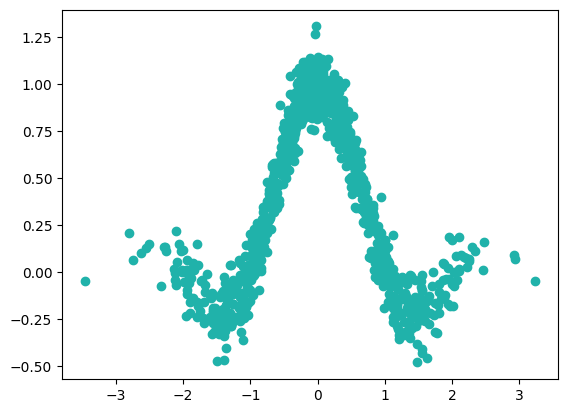

In [3]:
def Get_inf_data(func, noise_std, num_points):
    #draw x from normal distribution with mean = 0, std = 1
    x = np.random.normal(0, 1, num_points)
    #draw x from uniform distribution between -1 and 1
    #x = np.random.uniform(-10, 10, num_points)
    #draw noise from normal distribution with std = noise_std
    noise = np.random.normal(0, noise_std, num_points)
    #calculate y
    if func == 'cubic':
        f = lambda x: x**3

    elif func == 'sinc':
        f = lambda x: np.sinc(x * 1)

    y = f(x) + noise
    x, y = x.reshape(-1, 1), y.reshape(-1, 1)
    target = 1
    
    return x, y, target

x, y, target = Get_inf_data(func='sinc',
                                        noise_std=0.1,
                                        num_points=1000)

plt.scatter(x, y)
plt.show()

X


Init: sqe_len=0.6690398280149967, sqe_var=0.2689816314417701, lin_var=0.2689816314417701, lik_var=0.000253275245708366


2024-02-05 20:19:57.085388: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2024-02-05 20:19:57.085495: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory
2024-02-05 20:19:57.085574: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libcublasLt.so.11: cannot open shared object file: No such file or directory
2024-02-05 20:19:57.085650: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcufft.so.10'; dlerror: libcufft.so.10: cannot open shared object file: No such file or directory
2024-02-05 20:19:57.085726: W tensorflow/stream_executor/platform/default/dso_loader.cc:64

Instructions for updating:
`scale_identity_multiplier` is deprecated; please combine it into `scale_diag` directly instead.


Optimising with natgrad: 100%|██████████| 6000/6000 [02:56<00:00, 33.99it/s]

Found: sqe_len=1.1706458018622588, sqe_var=0.06513624558248889, lin_var=0.1480985864905292, lik_var=0.008823813067382539


Full Loss: 1483.3174618620244


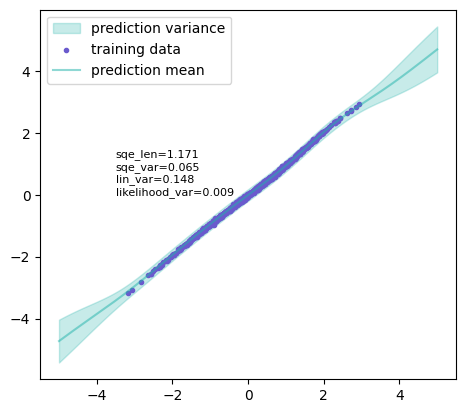

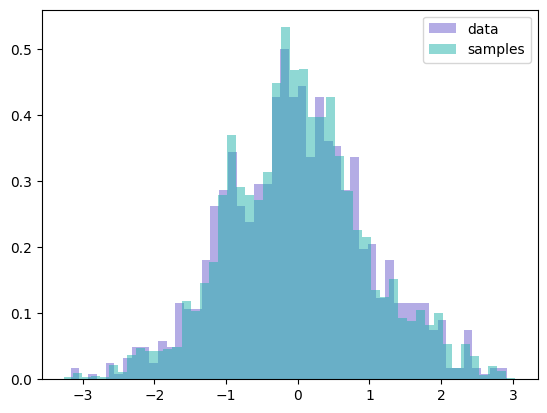

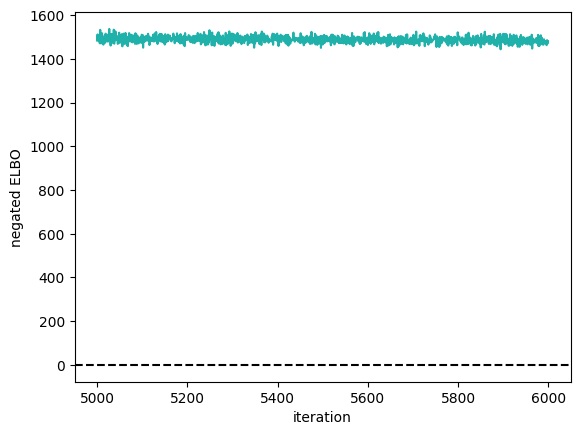

In [4]:
#fit marginal model using generalised GPLVM
"""
This method fits a GPLVM for marginal and conditional models.
Returns the marginal log likelihood and predictive loss for each
"""
from models.GeneralisedGPLVM import GeneralisedGPLVM
from models.GeneralisedUnsupGPLVM import GeneralisedUnsupGPLVM
from pathlib import Path
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm
from typing import Optional
import gpflow
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import gpflow
import matplotlib.pyplot as plt
from gpflow.config import default_float
import dill
from collections import defaultdict
from collections import namedtuple

def run_optimizer(
    optimiser, model, train_dataset, iterations, data_size, minibatch_size, adam_lr
):
    """
    Utility function running the Adam optimizer
    Modified from https://gpflow.readthedocs.io/en/master/notebooks/advanced/gps_for_big_data.html
    :param model: GPflow model
    :param interations: number of iterations
    """
    # Create an Adam Optimizer action
    logf = []
    #train_iter = iter(train_dataset.batch(minibatch_size)) 
    #make sure we are not using the same batch every time
    train_iter = iter(train_dataset.batch(minibatch_size))
    training_loss = model.training_loss_closure(train_iter, compile=True)

    if optimiser == "adam":
        optimizer = tf.optimizers.Adam(adam_lr)

        @tf.function
        def optimization_step():
            optimizer.minimize(training_loss, model.trainable_variables)

    elif optimiser == "natgrad":
        natgrad_opt = gpflow.optimizers.NaturalGradient(gamma=adam_lr)
        variational_params = [(model.q_mu, model.q_sqrt)]

        #prohibit training the variational parameters for Adam
        gpflow.utilities.set_trainable(model.q_mu, False)
        gpflow.utilities.set_trainable(model.q_sqrt, False)

        adam_opt = tf.optimizers.Adam(adam_lr)
        
        @tf.function
        def optimization_step():
            natgrad_opt.minimize(
                training_loss, var_list=variational_params
            )
            adam_opt.minimize(training_loss, var_list=model.trainable_variables)

    else:
        raise ValueError("optimiser must be 'adam' or 'natgrad'")

    iterator = range(iterations)
    for step in tqdm(iterator, desc=f"Optimising with {optimiser}"):
        optimization_step()
        neg_elbo = training_loss().numpy()
        logf.append(neg_elbo)
        # It is possible to include a stopping criteria here. However there
        # is a risk that the training will be stopped too soon and the
        # ELBO achieved will not be as high as it could be
    return logf


def train_marginal_model(
    y: np.ndarray,
    num_inducing: int,
    kernel_variance: float,
    kernel_lengthscale_1: float,
    likelihood_variance: float,
    num_minibatch: int,
    num_iterations: int, 
    optimiser: str,
    work_dir: str,
    save_name: str,
    adam_lr: float,
    causal: Optional[bool] = None,
    random_restart_number: Optional[int] = None,
    plot_fit: Optional[bool] = False,
):
    
    # Set random seed
    causal_offset = 1 if causal else 10
    size_offset = y.shape[0]
    seed = causal_offset * (size_offset + random_restart_number)
    rng = np.random.default_rng(seed)

    # Define kernels
    sq_exp = gpflow.kernels.SquaredExponential(
        lengthscales=kernel_lengthscale_1
    )
    sq_exp.variance.assign(kernel_variance)
    linear_kernel = gpflow.kernels.Linear(variance=kernel_variance)
    kernel = gpflow.kernels.Sum([sq_exp, linear_kernel])
    #Z = np.random.randn(num_inducing, 1)
    Z = rng.normal(size=(num_inducing, 1))
    # inducing_variable = gpflow.inducing_variables.InducingPoints(
    #     # np.random.randn(num_inducing, 1)
    #     Z
    # )
    # Z = inducing_variable
    # Define the approx posteroir
    X_mean_init = 0.1 * tf.cast(y, default_float())
    X_var_init = tf.cast(
        # np.random.uniform(0, 0.1, (y.shape[0], 1)), default_float()
        rng.uniform(0, 0.1, (y.shape[0], 1)), default_float()
    )

    # Define marginal model
    marginal_model = GeneralisedUnsupGPLVM(
        X_data_mean=X_mean_init,
        X_data_var=X_var_init,
        kernel=kernel,
        likelihood=gpflow.likelihoods.Gaussian(variance=likelihood_variance),
        num_mc_samples=10,
        inducing_variable=Z,
        batch_size=num_minibatch,
    )
    # Run optimisation
    tf.print("Init: sqe_len={}, sqe_var={}, lin_var={}, lik_var={}".format(
        marginal_model.kernel.kernels[0].lengthscales.numpy(),
        marginal_model.kernel.kernels[0].variance.numpy(),
        marginal_model.kernel.kernels[1].variance.numpy(),
        marginal_model.likelihood.variance.numpy(),
    ))

    data_idx = np.arange(y.shape[0])
    train_dataset = tf.data.Dataset.from_tensor_slices((y, data_idx)).repeat()
    logf = run_optimizer(
        optimiser=optimiser,
        model=marginal_model,
        train_dataset=train_dataset,
        iterations=num_iterations,
        adam_lr=adam_lr,
        data_size=y.shape[0],
        minibatch_size=num_minibatch,
    )
    tf.print("Found: sqe_len={}, sqe_var={}, lin_var={}, lik_var={}".format(
        marginal_model.kernel.kernels[0].lengthscales.numpy(),
        marginal_model.kernel.kernels[0].variance.numpy(),
        marginal_model.kernel.kernels[1].variance.numpy(),
        marginal_model.likelihood.variance.numpy(),
    ))

    marginal_model.num_mc_samples = 100
    full_elbo = marginal_model.elbo((y, data_idx))
    tf.print(f"Full Loss: {- full_elbo}")

    marg_ll = float(full_elbo)
    pred_loss = float(-marginal_model.predictive_score((y, data_idx)))


    if plot_fit:

        # Plot the fit to see if everything is ok
        obs_new = np.linspace(-5, 5, 1000)[:, None]

        pred_y_mean, pred_y_var = marginal_model.predict_y(
            Xnew=obs_new,
        )
        text_sqe = 'sqe_len=%.3f\nsqe_var=%.3f' % (
            marginal_model.kernel.kernels[0].lengthscales.numpy(),
            marginal_model.kernel.kernels[0].variance.numpy(),
        )
        text_lin = 'lin_var=%.3f' % (
            marginal_model.kernel.kernels[1].variance.numpy(),
        )
        text_likelihood = 'likelihood_var=%.3f' % (
            marginal_model.likelihood.variance.numpy(),
        )
        textstr = text_sqe + '\n' + text_lin + '\n' + text_likelihood

        plt.text(-3.5, 0, textstr, fontsize=8)
        plt.fill_between(
            obs_new[:, 0],
            (pred_y_mean + 2 * np.sqrt(pred_y_var))[:, 0],
            (pred_y_mean - 2 * np.sqrt(pred_y_var))[:, 0],
            alpha=0.25,
            color='C0',
            label='prediction variance'
        )

        plt.scatter(marginal_model.X_data_mean, y, c='C2', marker='.', label='training data')
        plt.plot(obs_new, pred_y_mean, c='C0', alpha=0.5, label='prediction mean')

        plt.legend()
        fname = f"marginal_" + save_name + ".jpg"
        save_dir = Path(f"{work_dir}/figs/run_plots/inf_data")
        save_dir.mkdir(
            parents=True, exist_ok=True
        )
        plt.subplots_adjust(left=0.25)
        
        plt.savefig(
            save_dir / fname
        )
        plt.show()
        plt.close()

        #histogram of y observed
        plt.hist(y, bins=50, density=True, color="C2", alpha=0.5, label="data")
        #histogram of samples from posterior
        samples = marginal_model.predict_f_samples(y, num_samples=500)
        samples = samples.numpy().reshape(-1)
        plt.hist(samples, bins=50, density=True, color="C0", alpha=0.5, label="samples")
        plt.legend()
        fname = f"marginal_" + save_name + "_hist.jpg"
        plt.savefig(
            save_dir / fname
        )
        plt.show()
        plt.close()

        #plot elbo over iterations with line at 0
        plt.axhline(y=0, color='black', linestyle='--')
        logf_arr = np.array(logf)[-1000:]
        iters_arr = np.arange(len(logf)-len(logf_arr), len(logf))
        plt.plot(iters_arr, logf_arr)
        plt.xlabel("iteration")
        plt.ylabel("negated ELBO")
        fname = f"marginal_" + save_name + "_elbo.jpg"
        plt.savefig(
            save_dir / fname
        )
        plt.show()
        plt.close()

    else:
        pass
    return marg_ll, pred_loss

def causal_scores(
    data,
    num_inducing,
    opt_iter,
    minibatch_size,
    set_size,
    plot_fit,
    optimiser,
    dataset_name: str="",
    work_dir: Optional[str] = ".",
    causal: Optional[bool] = True,
    random_restart_number: Optional[int] = 0,
):
    # Unpack data
    x, y = data
    causal_direction = "causal" if causal else "anticausal"
    save_name = f"{causal_direction}_{dataset_name}_size_{set_size}_ind_{num_inducing}_opt_{optimiser}_rr_{random_restart_number}"
    num_inducing = (
        num_inducing if x.shape[0] > num_inducing else x.shape[0]
    )

    # Set random seed
    causal_offset = 1 if causal else 10
    size_offset = set_size
    seed = causal_offset * (size_offset + random_restart_number)
    rng = np.random.default_rng(seed)
    # Set number of iterations
    num_iterations = opt_iter

    # Sample hyperparams
    kernel_variance = rng.uniform(low=0.1, high=1.0)
    # Likelihood variance
    kappa = rng.uniform(low=50.0, high=100.0, size=[1])
    likelihood_variance = 1.0 / (kappa**2)
    # Kernel lengthscale
    lamda = rng.uniform(low=1.0, high=2.0, size=[3])
    kernel_lengthscale = 1.0 / lamda
    adam_lr = 0.1

    tf.print("X" if causal else "Y")
    marg_ll_x, pred_loss_x = train_marginal_model(
        y=x,
        num_inducing=num_inducing,
        kernel_variance=kernel_variance,
        kernel_lengthscale_1=kernel_lengthscale[0],
        likelihood_variance=likelihood_variance[0],
        num_minibatch=minibatch_size,
        optimiser=optimiser,
        work_dir=work_dir,
        random_restart_number=random_restart_number,
        causal=causal,
        save_name=save_name,
        plot_fit=plot_fit,
        adam_lr=adam_lr,
        num_iterations=num_iterations,
    )

    return marg_ll_x, pred_loss_x

x, y, target = Get_inf_data(func='cubic',
                                        noise_std=2.0,
                                        num_points=1000)

data, _ = preprocess(x, y, test_size=0.0)

marg_ll_x, pred_loss_x = causal_scores(
    data=data,
    num_inducing=25,
    opt_iter=6000,
    minibatch_size=500,
    set_size=data[0].shape[0],
    plot_fit=True,
    optimiser="natgrad",
    dataset_name="inf_data",
    work_dir="../",
    causal=True,
    random_restart_number=3,
)

# generalised unsup gplvm

In [ ]:
"""
This method will fit a gplvm for both the marginal and conditional models and
choose the causal direction as the one with the minimum
-log marginal likelihood.
"""
from models.GeneralisedGPLVM import GeneralisedGPLVM
from models.GeneralisedUnsupGPLVM import GeneralisedUnsupGPLVM
from pathlib import Path
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm
from tqdm import trange
from typing import Optional
import gpflow
import matplotlib.pyplot as plt
import numpy as np
import pickle
import tensorflow as tf
from gpflow.quadrature import NDiagGHQuadrature
from tqdm import trange
from gpflow.optimizers import NaturalGradient
import gpflow
import matplotlib.pyplot as plt
from gpflow.config import default_float
import dill
from collections import defaultdict
from collections import namedtuple

adam_learning_rates = [0.05, 0.01]


GPLVM_SCORES = namedtuple('GPLVM_SCORES', 'loss_x loss_y_x loss_y loss_x_y')


def run_optimizer(model, train_dataset, iterations, data_size, minibatch_size, adam_lr):
    """
    Utility function running the Adam optimizer
    Modified from https://gpflow.readthedocs.io/en/master/notebooks/advanced/gps_for_big_data.html
    :param model: GPflow model
    :param interations: number of iterations
    """
    # Create an Adam Optimizer action
    logf = []
    #train_iter = iter(train_dataset.batch(minibatch_size))
    train_iter = iter(train_dataset.batch(minibatch_size))

    training_loss = model.training_loss_closure(train_iter, compile=True)
    optimizer = tf.optimizers.Adam(adam_lr)
    @tf.function
    def optimization_step():
        optimizer.minimize(training_loss, model.trainable_variables)
    iterator = range(iterations)
    for step in iterator:
        print("Step: {} / {}  ".format(step, iterations), end='\r')
        optimization_step()
        neg_elbo = training_loss().numpy()
        logf.append(neg_elbo)
        # if step % 5000 == 0:

            # iterator.set_description(f"EPOCH: {step}, NEG ELBO: {neg_elbo}")

            # if step / float(data_size / minibatch_size) > 10000:
            #     if np.abs(np.mean(logf[-5000:])) - np.abs(np.mean(logf[-100:])) < 0.2 * np.std(logf[-100:]):
            #         print(f"\n BREAKING! Step: {step} \n")
            #         break
    return logf


def train_marginal_model(
    y: np.ndarray,
    num_inducing: int,
    kernel_variance: float,
    kernel_lengthscale_1: float,
    kernel_lengthscale_2: float,
    kernel_lengthscale_3: float,
    likelihood_variance: float,
    num_minibatch: int,
    num_iterations: int,
    work_dir: str,
    save_name: str,
    adam_lr: float,
    causal: Optional[bool] = None,
    run_number: Optional[int] = None,
    random_restart_number: Optional[int] = None,
    plot_fit: Optional[bool] = False,
):
    # Define kernels
    sq_exp = gpflow.kernels.SquaredExponential(lengthscales=kernel_lengthscale_1)
    sq_exp.variance.assign(kernel_variance)
    matern = gpflow.kernels.Matern32(lengthscales=kernel_lengthscale_2)
    matern.variance.assign(kernel_variance)
    rquadratic = gpflow.kernels.RationalQuadratic(lengthscales=kernel_lengthscale_3)
    rquadratic.variance.assign(kernel_variance)
    linear_kernel = gpflow.kernels.Linear(variance=kernel_variance)
    kernel = gpflow.kernels.Sum([sq_exp, linear_kernel, matern, rquadratic])
    Z = np.random.randn(num_inducing, 1)

    # Define the approx posteroir
    X_mean_init = 0.1 * tf.cast(y, default_float())
    X_var_init = tf.cast(
        np.random.uniform(0, 0.1, (y.shape[0], 1)), default_float()
    )

    # Define marginal model
    marginal_model = GeneralisedUnsupGPLVM(
        X_data_mean=X_mean_init,
        X_data_var=X_var_init,
        kernel=kernel,
        likelihood=gpflow.likelihoods.Gaussian(variance=likelihood_variance),
        num_mc_samples=10,
        inducing_variable=Z,
        batch_size=num_minibatch,
    )
    # Run optimisation

    data_idx = np.arange(y.shape[0])
    train_dataset = tf.data.Dataset.from_tensor_slices((y, data_idx)).repeat()
    logf = run_optimizer(
        model=marginal_model,
        train_dataset=train_dataset,
        iterations=num_iterations,
        adam_lr=adam_lr,
        data_size=y.shape[0],
        minibatch_size=num_minibatch,
    )

    marginal_model.num_mc_samples = 100
    full_elbo = marginal_model.elbo((y, data_idx))
    print(f"Full Loss: {- full_elbo}")

    loss = - full_elbo

    if plot_fit:
        # Plot the fit to see if everything is ok
        lower, median, upper, samples = marginal_model.predict_credible_layer(
            obs_noise=True,
            sample_size=1000
        )
        textstr = 'like_var=%.2f\nneg_elbo=%.2f\n'%(
            marginal_model.likelihood.variance.numpy(),
            loss.numpy()
        )
        plt.text(-8, 0, textstr, fontsize=8)
        #use same bins for all plots
        bins = np.linspace(-5, 5, 100)
        plt.hist(y, bins=bins, density=True, color="C2", alpha=0.5, label="data")
        plt.hist(samples.numpy().reshape(-1), bins=bins, density=True, color="C0", alpha=0.5, label="samples")
        plt.legend()

        plt.xlim(-5, 5)
        plt.legend()

        save_dir = Path(f"{work_dir}/run_plots/{save_name}")
        save_dir.mkdir(
            parents=True, exist_ok=True
        )
        plt.subplots_adjust(left=0.25)
        causal_direction = "causal" if causal else "anticausal"
        plt.show()
        plt.close()

        #plot latent space
        obs_new = np.linspace(-2, 2, 1000)[:, None]

        pred_y_mean, pred_y_var = marginal_model.predict_y(
            Xnew=obs_new,
        )
        text_sqe = 'sqe_len=%.3f\nsqe_var=%.3f' % (
            marginal_model.kernel.kernels[0].lengthscales.numpy(),
            marginal_model.kernel.kernels[0].variance.numpy(),
        )
        text_lin = 'lin_var=%.3f' % (
            marginal_model.kernel.kernels[1].variance.numpy(),
        )
        text_likelihood = 'likelihood_var=%.3f' % (
            marginal_model.likelihood.variance.numpy(),
        )
        textstr = text_sqe + '\n' + text_lin + '\n' + text_likelihood

        plt.text(-3.5, 0, textstr, fontsize=8)
        plt.fill_between(
            obs_new[:, 0],
            (pred_y_mean + 2 * np.sqrt(pred_y_var))[:, 0],
            (pred_y_mean - 2 * np.sqrt(pred_y_var))[:, 0],
            alpha=0.25,
            color='C0',
            label='prediction variance'
        )

        plt.scatter(marginal_model.X_data_mean[:, 0], y, c='C2', marker='.', label='training data')
        plt.plot(obs_new, pred_y_mean, c='C0', alpha=0.5, label='prediction mean')

        plt.legend()
        plt.show()

        #plot elbo over iterations
        logf_arr = np.array(logf)[-1000:]
        iters_arr = np.arange(len(logf)-len(logf_arr), len(logf))
        plt.plot(iters_arr, logf_arr)
        plt.xlabel("iteration")
        plt.ylabel("negated ELBO")
        plt.show()

    else:
        pass
    return loss


def causal_score_gplvm_generalised(x, y, run_number, restart_number, causal, save_name, plot_fit=True, minibatch_size=100, work_dir="../", num_inducing=100, num_iterations=10000):
    num_inducing = num_inducing if x.shape[0] > num_inducing else x.shape[0]
    # Set number of iterations
    #num_iterations = int(x.shape[0] / minibatch_size * 6666.67 * 2)

    # Sample hyperparams
    kernel_variance = 1.0
    loss_x = None
    # Likelihood variance
    kappa = np.random.uniform(
        low=30.0, high=100, size=[1]
    )
    likelihood_variance = 1. / (kappa ** 2)
    # Kernel lengthscale
    lamda = np.random.uniform(
        low=1, high=100, size=[3]
    )
    
    kernel_lengthscale = 1.0 / lamda
    adam_lr = np.random.choice(adam_learning_rates)

    tf.print("X" if causal else "Y")
    loss_x = train_marginal_model(
        y=x,
        num_inducing=num_inducing,
        kernel_variance=kernel_variance,
        kernel_lengthscale_1=kernel_lengthscale[0],
        kernel_lengthscale_2=kernel_lengthscale[1],
        kernel_lengthscale_3=kernel_lengthscale[2],
        likelihood_variance=likelihood_variance[0],
        num_minibatch=minibatch_size,
        work_dir=work_dir,
        run_number=run_number,
        random_restart_number=restart_number,
        causal=causal,
        save_name=save_name,
        plot_fit=plot_fit,
        adam_lr=adam_lr,
        num_iterations=num_iterations,
    )

    return loss_x


#run on inf data
x, y, target = Get_inf_data(func='cubic',
                                        noise_std=2.0,
                                        num_points=1000)

loss_x = causal_score_gplvm_generalised(
    x=x,
    y=y,
    run_number=1,
    restart_number=1,
    causal=True,
    save_name="inf_data",
    plot_fit=True,
    minibatch_size=15,
    work_dir="../",
    num_inducing=25,
    num_iterations=5000,
)

# # train_iter = iter(train_dataset.batch(minibatch_size))
# data_idx = np.arange(y.shape[0]).reshape(-1, 1)
# print(data_idx)
# y = tf.data.Dataset.from_tensor_slices((y, data_idx))#.repeat()
# #print the result of the slice
# # for i in y:
# #     print(i)

# Y = y.batch(10)
# Y = iter(Y)
# print(next(Y))


In [ ]:
print(next(Y))
